In [3]:
# Start the cluster
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
#set up data
cores = 4
cluster = ipp.Cluster(engines="mpi", n=cores)
cluster.engine_launcher_class.mpi_args = ["--use-hwthread-cpus"]
client = cluster.start_and_connect_sync()
client.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

engine set stopped 1659779680: {'exit_code': -1, 'pid': 11328, 'identifier': 'ipengine-1659779679-2zz5-1659779680-10916'}


EngineError: Engine set stopped: {'exit_code': -1, 'pid': 11328, 'identifier': 'ipengine-1659779679-2zz5-1659779680-10916'}

In [2]:
%%px
# includes
import numpy as np
from source.algorithms.latticeBoltzman import LatticeBoltzmannMethod
from source.algorithms.ParallelCommunication import ParallelGridManager
import source.algorithms.BoundaryCondition as bc
import source.data.CommonDefinitions as cd
import matplotlib.pyplot as plt
import matplotlib as mpl
print("imports done")

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:3] imports done


[stdout:2] imports done


[stdout:0] imports done


[stdout:1] imports done


In [3]:
# X, Y = 400 , 400
# from source.algorithms.ParallelCommunication import ParallelGridManager
# manager = ParallelGridManager(X, Y)

In [4]:
%%px
#set up data
X, Y = 300, 300
omega = 1.0
time_steps = 1000
plt.style.use('classic')

# velocities = [0.25, 0.5, 0.75, 1.0]
velocities = [0.5]
# raynoldsnumbers = [250, 500,750,1000]
raynoldsnumbers = [1000]
omegas = np.ndarray((len(velocities), len(raynoldsnumbers)))

raynold_else_tuple = []
for r_idx, raynold in enumerate(raynoldsnumbers):
    velo_omega_tuple = []
    for v_idx, velo in enumerate(velocities):
        velo_omega_tuple.append([cd.get_omega_for_raynoldnumb(raynold, velo, 300), velo])
    raynold_else_tuple.append([raynold, velo_omega_tuple])

test_data_dict = dict(list(raynold_else_tuple))

set up LBM-class in parallel and execute it 

[stdout:1] start init parallel communication
[0 0 0 0 3 3 3 3]
loc_X: 151 loc_Y: 151
Rigid Wall at BoundaryAlignments.RIGHT
Moving Wall at BoundaryAlignments.TOP
[0, 1]
0
6
0
0
0


[stdout:3] start init parallel communication
[2 2 2 2 1 1 1 1]
loc_X: 151 loc_Y: 151
Rigid Wall at BoundaryAlignments.RIGHT
Rigid Wall at BoundaryAlignments.BOTTOM
[1, 1]
0
4611686018427387904
0
44402
0


[stdout:2] start init parallel communication
[3 3 3 3 0 0 0 0]
loc_X: 151 loc_Y: 151
Rigid Wall at BoundaryAlignments.LEFT
Rigid Wall at BoundaryAlignments.BOTTOM
[1, 0]
0
4611686018427387904
0
44402
0


[stdout:0] start init parallel communication
[1 1 1 1 2 2 2 2]
loc_X: 151 loc_Y: 151
Rigid Wall at BoundaryAlignments.LEFT
Moving Wall at BoundaryAlignments.TOP
[0, 0]
0
6
0
0
0


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:0] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[stderr:2] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[stderr:1] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[stderr:3] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[output:0]

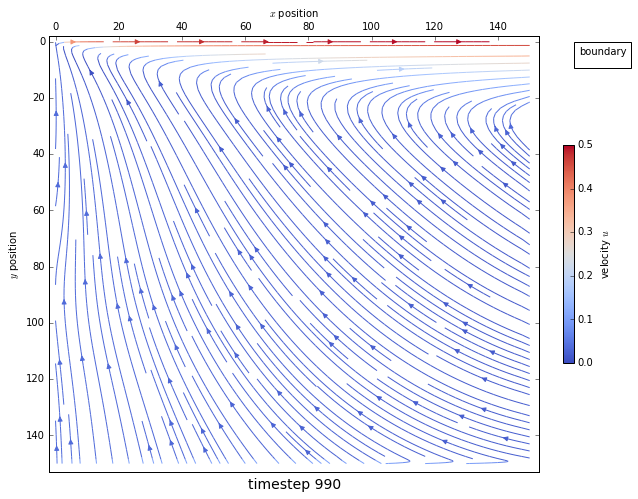

[output:3]

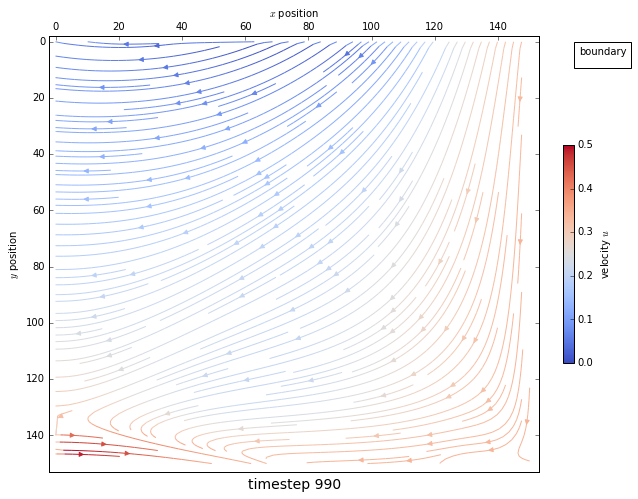

[output:2]

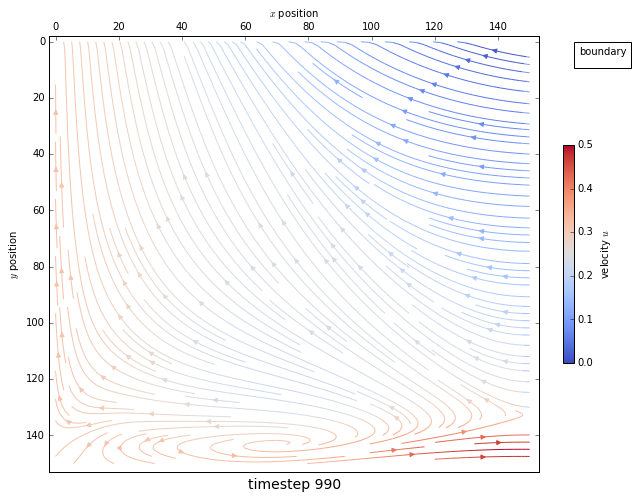

[output:1]

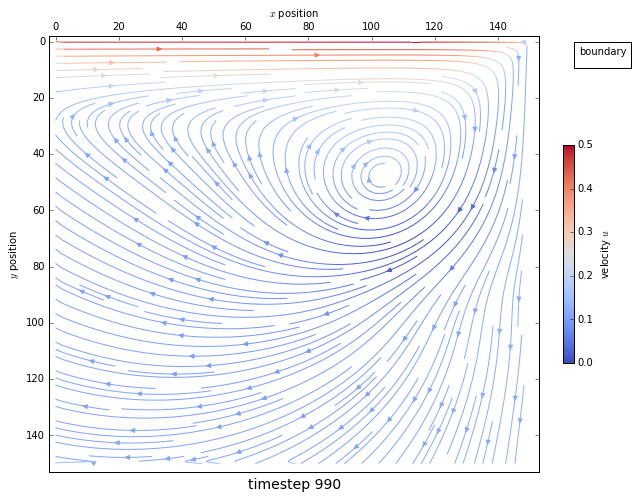

In [13]:
%%px
manager = ParallelGridManager(X, Y)
# print(manager._cartcomm)
# allrcoords = manager.comm.gather(manager._rcoords,root = 0)

# allDestSourBuf = np.zeros(manager._size*8, dtype = int)
# comm.Gather(sd, allDestSourBuf, root = 0)
# if manager._rank == 0:
#     print(allrcoords)
#     print(allDestSourBuf)
#     cartarray = np.ones((4,4))
#     allDestSour = np.array(allDestSourBuf).reshape((manager._size,8))
#     for i in np.arange(manager._size):
#         cartarray[allrcoords[i][0],allrcoords[i][1]] = i
#         #print(allDestSour[i,:])
#     print(cartarray)
def callback(lattice: LatticeBoltzmannMethod, t: int) -> None:
    velocities[t] = lattice.getVelocity()

loc_X, loc_Y = manager.local_buffer_shape
density_field = np.ones((loc_Y, loc_X))
velocity_field = np.zeros((2, loc_Y,loc_X))
for key, values in test_data_dict.items():
    for value in values:
        velocities = np.zeros((time_steps,2, loc_Y,loc_X), dtype=np.float64)
        this_omega = value[0] 
        wall_speed = np.array([0,value[1]  ])
        lattice = LatticeBoltzmannMethod(loc_X, loc_Y, omega=this_omega , init_density=density_field, init_velocity=velocity_field, init_plot=False, parallel_comm=manager)
        boundary_list = []
        if manager.isLeftBorder():
            boundary_list.append(bc.RigidWall(cd.BoundaryAlignments.LEFT, lattice=lattice ))
        if manager.isRightBorder():
            boundary_list.append(bc.RigidWall(cd.BoundaryAlignments.RIGHT, lattice=lattice ))
        if manager.isBottomBorder():
            boundary_list.append(bc.RigidWall(cd.BoundaryAlignments.BOTTOM, lattice=lattice ))
        if manager.isTopBorder():
            boundary_list.append(bc.MovingWall(cd.BoundaryAlignments.TOP, lattice=lattice, wall_velo=wall_speed ))

        print(manager.rcoords)
        boundary_handling = bc.BoundaryHandlings(boundary_conditions=boundary_list)
        lattice.execute(timesteps=time_steps, callback=callback, boundary=boundary_handling)
        #visualization
        time =990
        manager.save_mpiio(manager.cartcomm, 'uxRe{}.npy'.format(key), velocities[time, 0, manager.valid_y[0]:manager.valid_y[1],  manager.valid_x[0]:manager.valid_x[1]])
        manager.save_mpiio(manager.cartcomm, 'uyRe{}.npy'.format(key), velocities[time, 1,  manager.valid_y[0]:manager.valid_y[1], manager.valid_x[0]:manager.valid_x[1]])
        
        filename = "velocitiesRe"+str(int(key))+"Core"+str( manager.rank) 
        np.save("log/mpiio/singlecores/{}".format(filename), velocities[time,...])
        fig, ax = plt.subplots(figsize=(9,7))
        x, y = np.meshgrid(np.arange(loc_X), np.arange(loc_Y))
        cmap = "coolwarm"
        # velo_timesteps = np.arange(1,17,1)
        plt.subplot()
        plt.title("timestep {}".format(time), size=14, y=-0.05)
        plt.xlim(-2, loc_X+2)
        plt.xlabel('$x$ position')
        plt.ylabel('$y$ position')
        plt.ylim(-2, loc_Y+2)
        vy = velocities[time, 0, :, :]
        vx = velocities[time, 1, :, :]
        try:
            plt.streamplot(x, y, vx, vy, color=vx, density=2, cmap=cmap)
        except:
            print("could not do streamplot (maybe array is empty)")
        # plt.plot(np.arange(0,  loc_X+10,50), np.ones((int((loc_Y+2)//50)+1))*-0.5,color='r', marker = '>',markersize=10,linewidth=2, label="moving $U_x={}$".format(wall_speed[1]))
        # plt.plot(np.arange(-1, loc_X+1), np.ones((loc_Y+2))*(loc_Y+0.5), 'k', linewidth=2, label="rigid")
        # plt.plot(np.ones((loc_X))*-.5, range(loc_Y), 'k', linewidth=2, )
        # plt.plot(np.ones((loc_X))*(loc_X+.5), range(loc_Y), 'k', linewidth=2)
        ax.legend(title="boundary" ,bbox_to_anchor=(1.2, 1.0), prop={'size':12})
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")
        color_norm = mpl.colors.Normalize(vmin=0.0, vmax=wall_speed[1])
        fig.tight_layout()
        p = ax.get_position()
        fig.colorbar(mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap), \
            ax=fig.add_axes([p.x0+0.15, p.y0,p.width, p.height], visible=False), label='velocity $u$', shrink=0.5)
        plt.show()

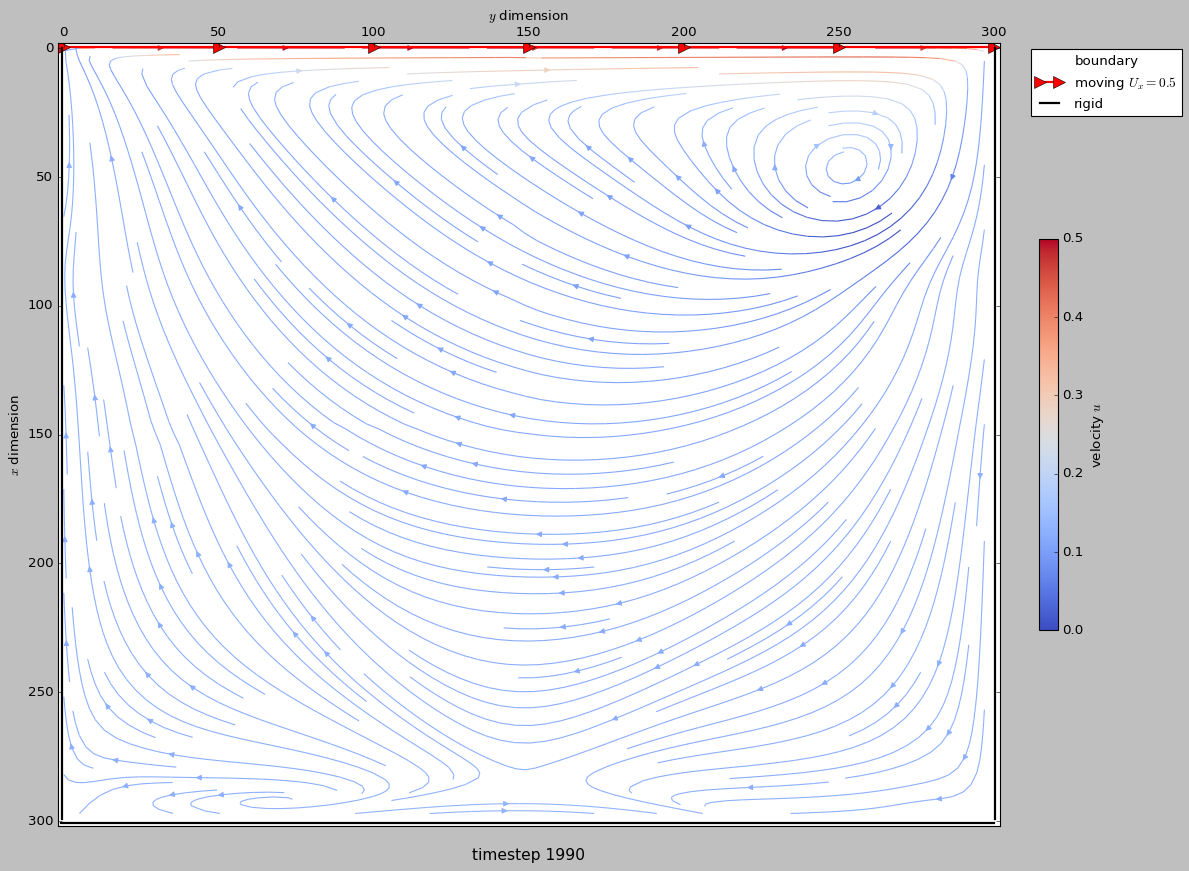

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

X, Y = 300, 300
omega = 1.0
time_steps = 1000
plt.style.use('classic')

ux_kl = np.load('log/mpiio/uxRe1000.npy')
uy_kl = np.load('log/mpiio/uyRe1000.npy')

nx, ny = ux_kl.shape
x_k = np.arange(nx)
y_l = np.arange(ny)
fig, ax = plt.subplots(figsize=(15,11))
cmap = "coolwarm"
wall_speed = []
wall_speed.append(0)
wall_speed.append(0.5)
plt.subplot()
plt.title("timestep {}".format(1990), size=14, y=-0.05)
plt.xlim(-2, X+2)
plt.xlabel('$y$ dimension')
plt.ylabel('$x$ dimension')
plt.ylim(-2, Y+2)
plt.streamplot(x_k, y_l, uy_kl, ux_kl,color=uy_kl, density=2, cmap=cmap)
plt.plot(np.arange(0,  X+10,50), np.ones((int((Y+2)//50)+1))*-0.5,color='r', marker = '>',markersize=10,linewidth=2, label="moving $U_x={}$".format(wall_speed[1]))
plt.plot(np.arange(-1, X+1), np.ones((Y+2))*(Y+0.5), 'k', linewidth=2, label="rigid")
plt.plot(np.ones((X))*-.5, range(Y), 'k', linewidth=2, )
plt.plot(np.ones((X))*(X+.5), range(Y), 'k', linewidth=2)
ax.legend(title="boundary" ,bbox_to_anchor=(1.2, 1.0), prop={'size':12})
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
color_norm = mpl.colors.Normalize(vmin=0.0, vmax=wall_speed[1])
fig.tight_layout()
p = ax.get_position()
fig.colorbar(mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap), \
    ax=fig.add_axes([p.x0+0.15, p.y0,p.width, p.height], visible=False), label='velocity $u$', shrink=0.5)
plt.show()

In [7]:
"""
puzzle lattice by hand toghether
--> not needed if the save magic (save_mpiio()) function works correctly

"""

from source.algorithms.ParallelCommunication import ParallelGridManager
manager = ParallelGridManager(X, Y)
rows, columns = manager.splid_global_grid
final_velo = np.zeros((2,Y,X))
timestep = 1990
for rank in range(cores):
    
    filename = "log/mpiio/singlecores/velocitiesRe"+str(1000)+"Core"+str(rank)+".npy" 
    velo_data = np.load(filename)
    print(velo_data.shape)
    print(int(rank/2))
    x_start = int( rank%rows*200)
    y_start = int(int(rank/columns) * 200)
    if (rank == 0):
        x_start, y_start = 200, 200
    if (rank == 3):
        x_start, y_start = 0, 0
    final_velo[:, y_start:200+y_start, x_start: 200+x_start] = velo_data[:, 0:200, 0:200]

# nx, ny = ux_kl.shape
x_k = np.arange(X)
y_l = np.arange(Y)
fig, ax = plt.subplots(figsize=(15,11))
cmap = "coolwarm"
wall_speed = []
wall_speed.append(0)
wall_speed.append(0.5)
plt.subplot()
plt.title("timestep {}".format(timestep), size=14, y=-0.05)
plt.xlim(-2, X+2)
plt.xlabel('$x$ position')
plt.ylabel('$y$ position')
plt.ylim(-2, Y+2)
plt.streamplot(x_k, y_l, final_velo[1], final_velo[0], color=final_velo[1], density=2, cmap=cmap)
plt.plot(np.arange(0,  X+10,50), np.ones((int((Y+2)//50)+1))*-0.5,color='r', marker = '>',markersize=10,linewidth=2, label="moving $U_x={}$".format(wall_speed[1]))
plt.plot(np.arange(-1, X+1), np.ones((Y+2))*(Y+0.5), 'k', linewidth=2, label="rigid")
plt.plot(np.ones((X))*-.5, range(Y), 'k', linewidth=2, )
plt.plot(np.ones((X))*(X+.5), range(Y), 'k', linewidth=2)
ax.legend(title="boundary" ,bbox_to_anchor=(1.2, 1.0), prop={'size':12})
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
color_norm = mpl.colors.Normalize(vmin=0.0, vmax=wall_speed[1])
fig.tight_layout()
p = ax.get_position()
fig.colorbar(mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap), \
    ax=fig.add_axes([p.x0+0.15, p.y0,p.width, p.height], visible=False), label='velocity $u$', shrink=0.5)
plt.show()


start init parallel communication
[0 0 0 0 0 0 0 0]
(2, 151, 151)
0


ValueError: could not broadcast input array from shape (2,151,151) into shape (2,100,100)

In [1]:
X= Y = 300
def getMLUPS(execution_time):
    return (X * Y * 100000 * 10e-7 /execution_time)

print(getMLUPS(72.051 ))



124.91152100595411


<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

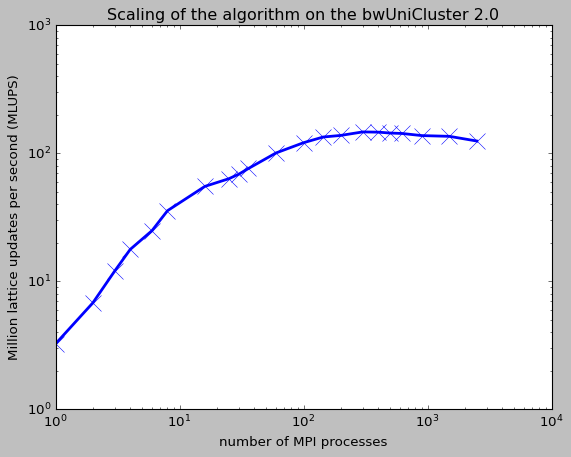

In [5]:
filename = "log/measurements bwUniCluster/combined.txt"

plt.style.use('classic')

from numpy import loadtxt
lines = loadtxt(filename, comments="#", delimiter=",", unpack=False)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lines[:, 0], lines[:,1 ], "x-", markersize=14, linewidth=2.5)
ax.set_title("Scaling of the algorithm on the bwUniCluster 2.0")
# ax.set_xlim(0, 1000)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("number of MPI processes")
ax.set_ylabel("Million lattice updates per second (MLUPS)")

plt.savefig(f'figures/Milestone7/Scaling.png', bbox_inches='tight')
fig.show